In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train_df = pd.read_csv('./zhengqi_train.txt', sep='\t', encoding='utf-8')
test_df = pd.read_csv('./zhengqi_test.txt', sep='\t', encoding='utf-8')

In [3]:
# train_df.info()

In [4]:
# test_df.info()

In [5]:
# train_df.describe()

In [6]:
# test_df.describe()

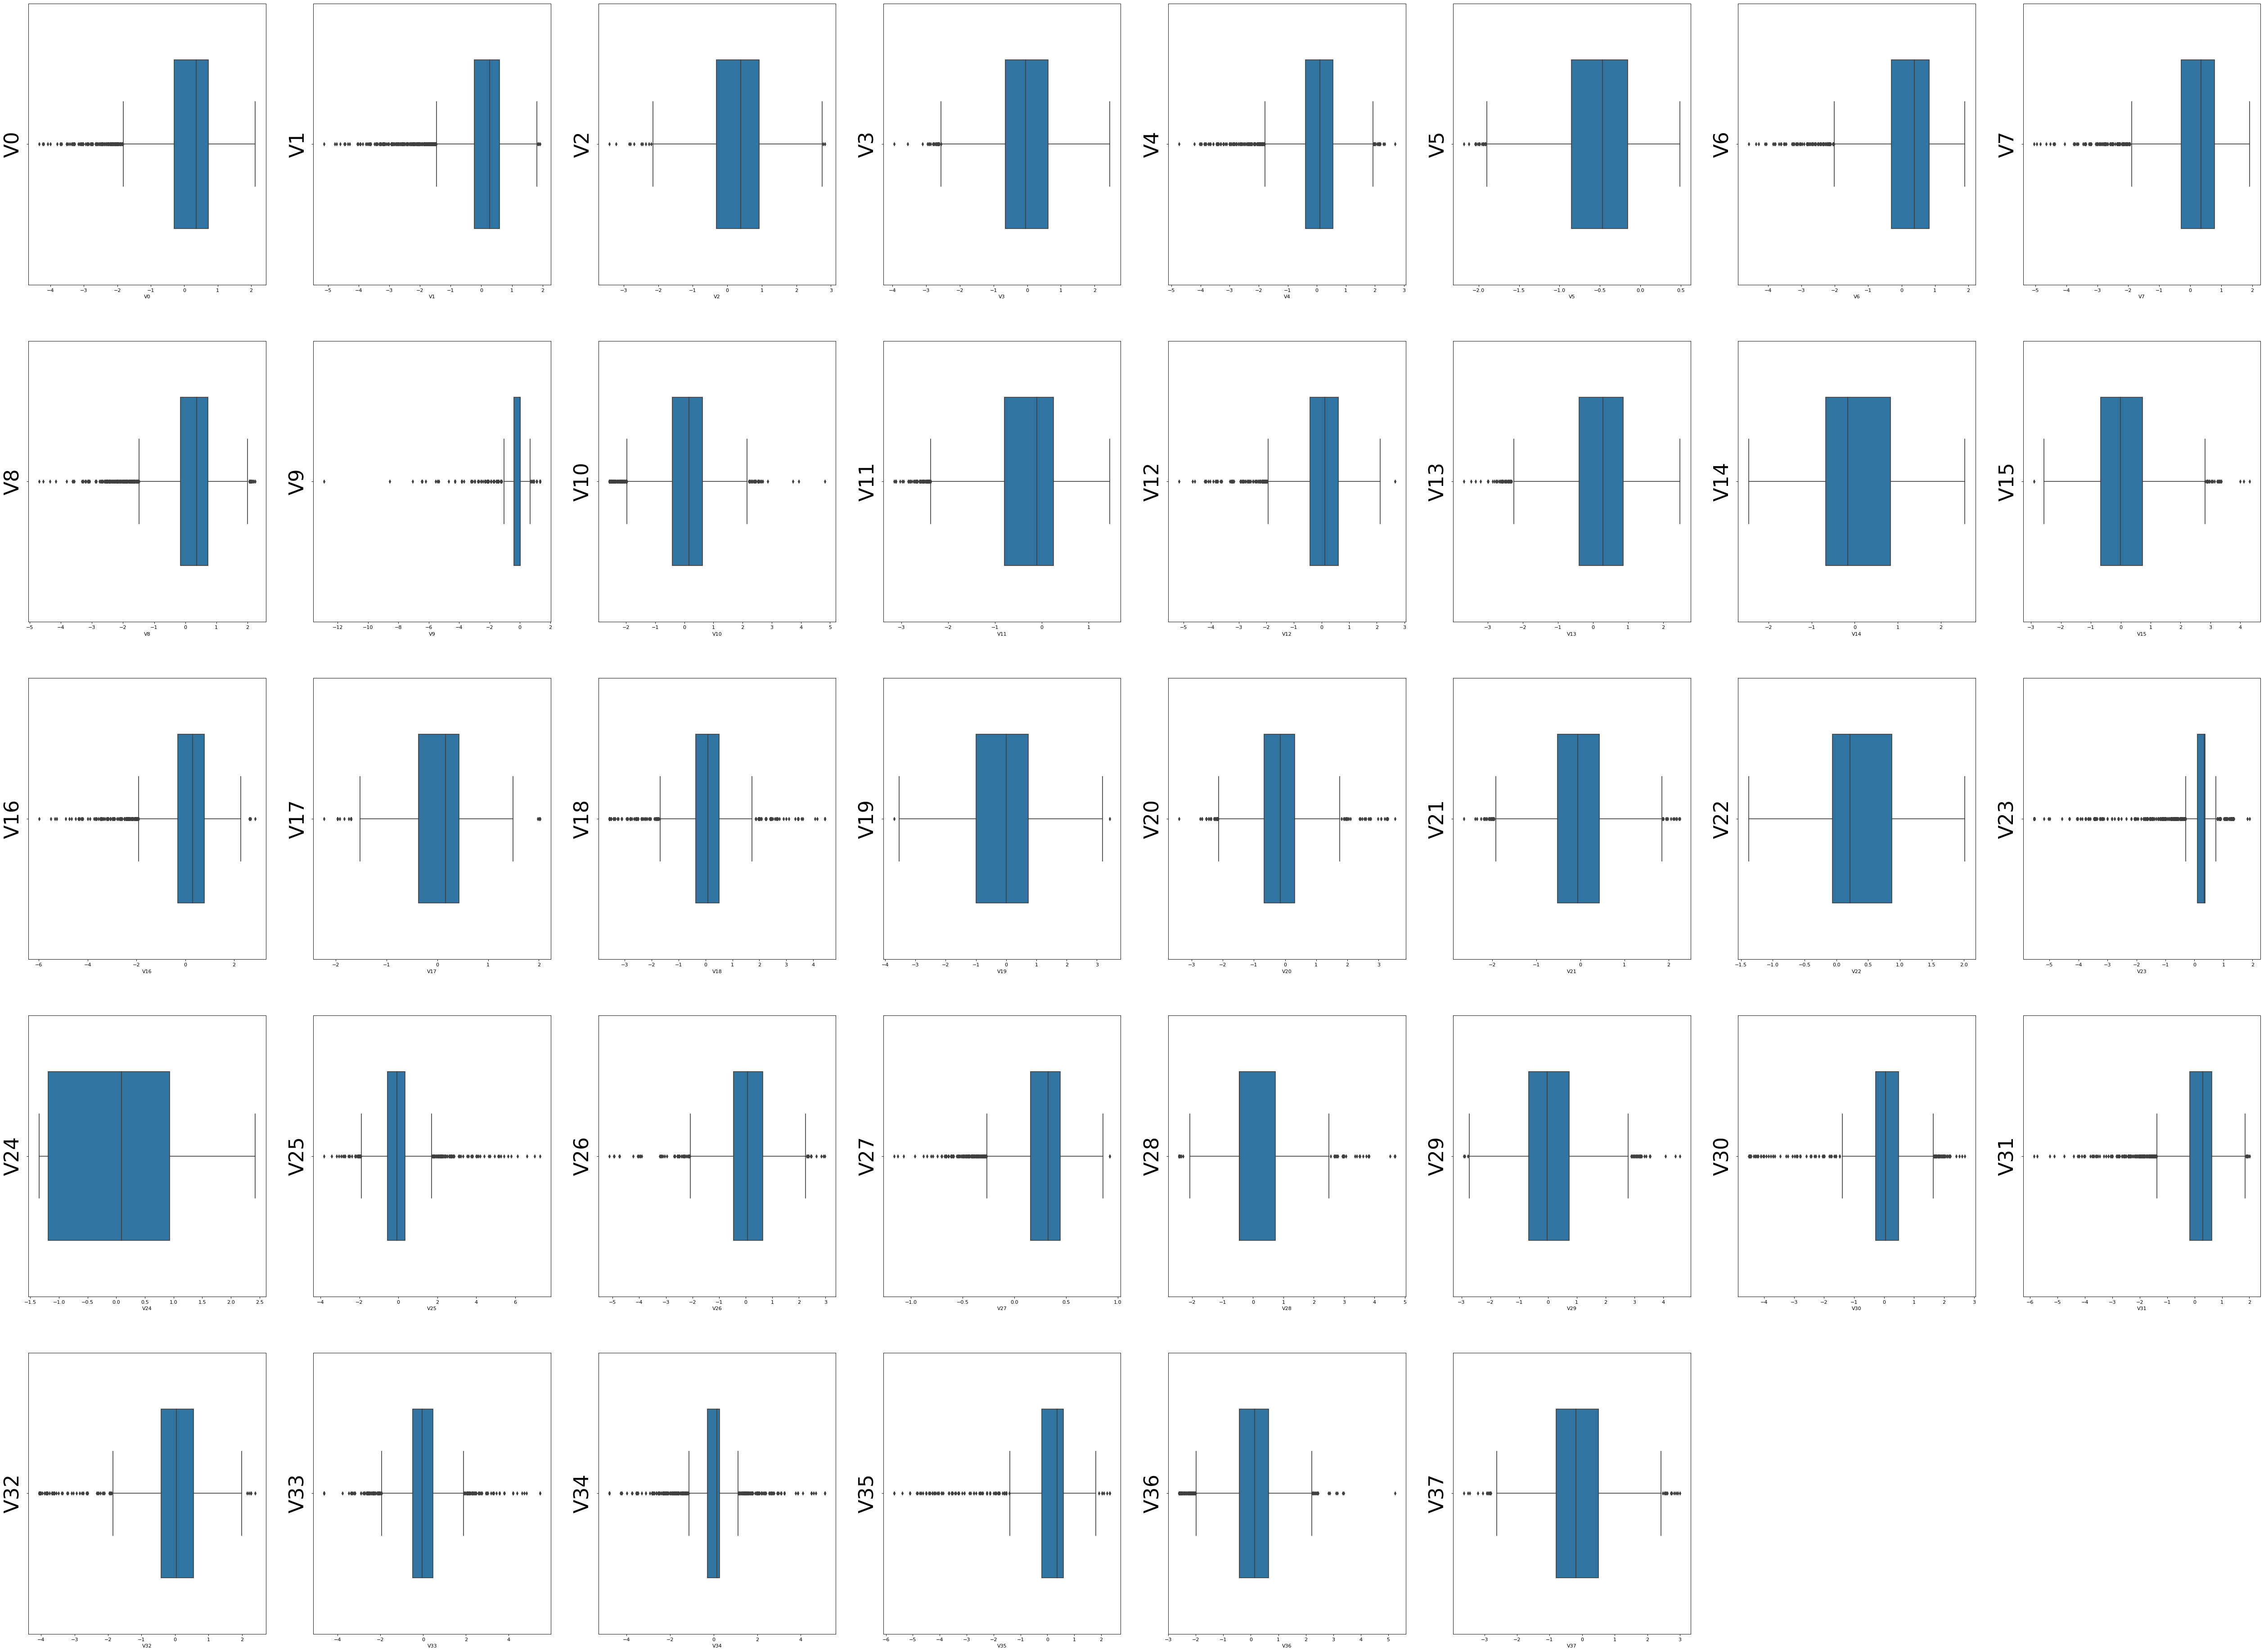

In [7]:
train_column = train_df.columns.tolist()[:38]
fig = plt.figure(figsize=(80, 60), dpi=80)
for i in range(38):
    plt.subplot(5, 8, i+1)
    sns.boxplot(train_df[train_column[i]], orient='h', width=0.6)
    plt.ylabel(train_column[i], fontsize=40)

plt.show()

In [8]:
def remove_train_outliers(dataset):
    
    for feature_col in dataset.columns[:-1]:
        Q1 = dataset.loc[:,feature_col].quantile(0.25)
        Q3 = dataset.loc[:,feature_col].quantile(0.75)
        IQR = Q3 - Q1
    
        upper_bound = Q3 + 1.5 * IQR
        lower_bound = Q1 - 1.5 * IQR
    
        outliers = (dataset[feature_col] > upper_bound) | (dataset[feature_col] < lower_bound)
    
        filtered_dataset = dataset[~outliers]
    
    return filtered_dataset

In [9]:
train_df = remove_train_outliers(train_df)

In [10]:
# train_df.describe()

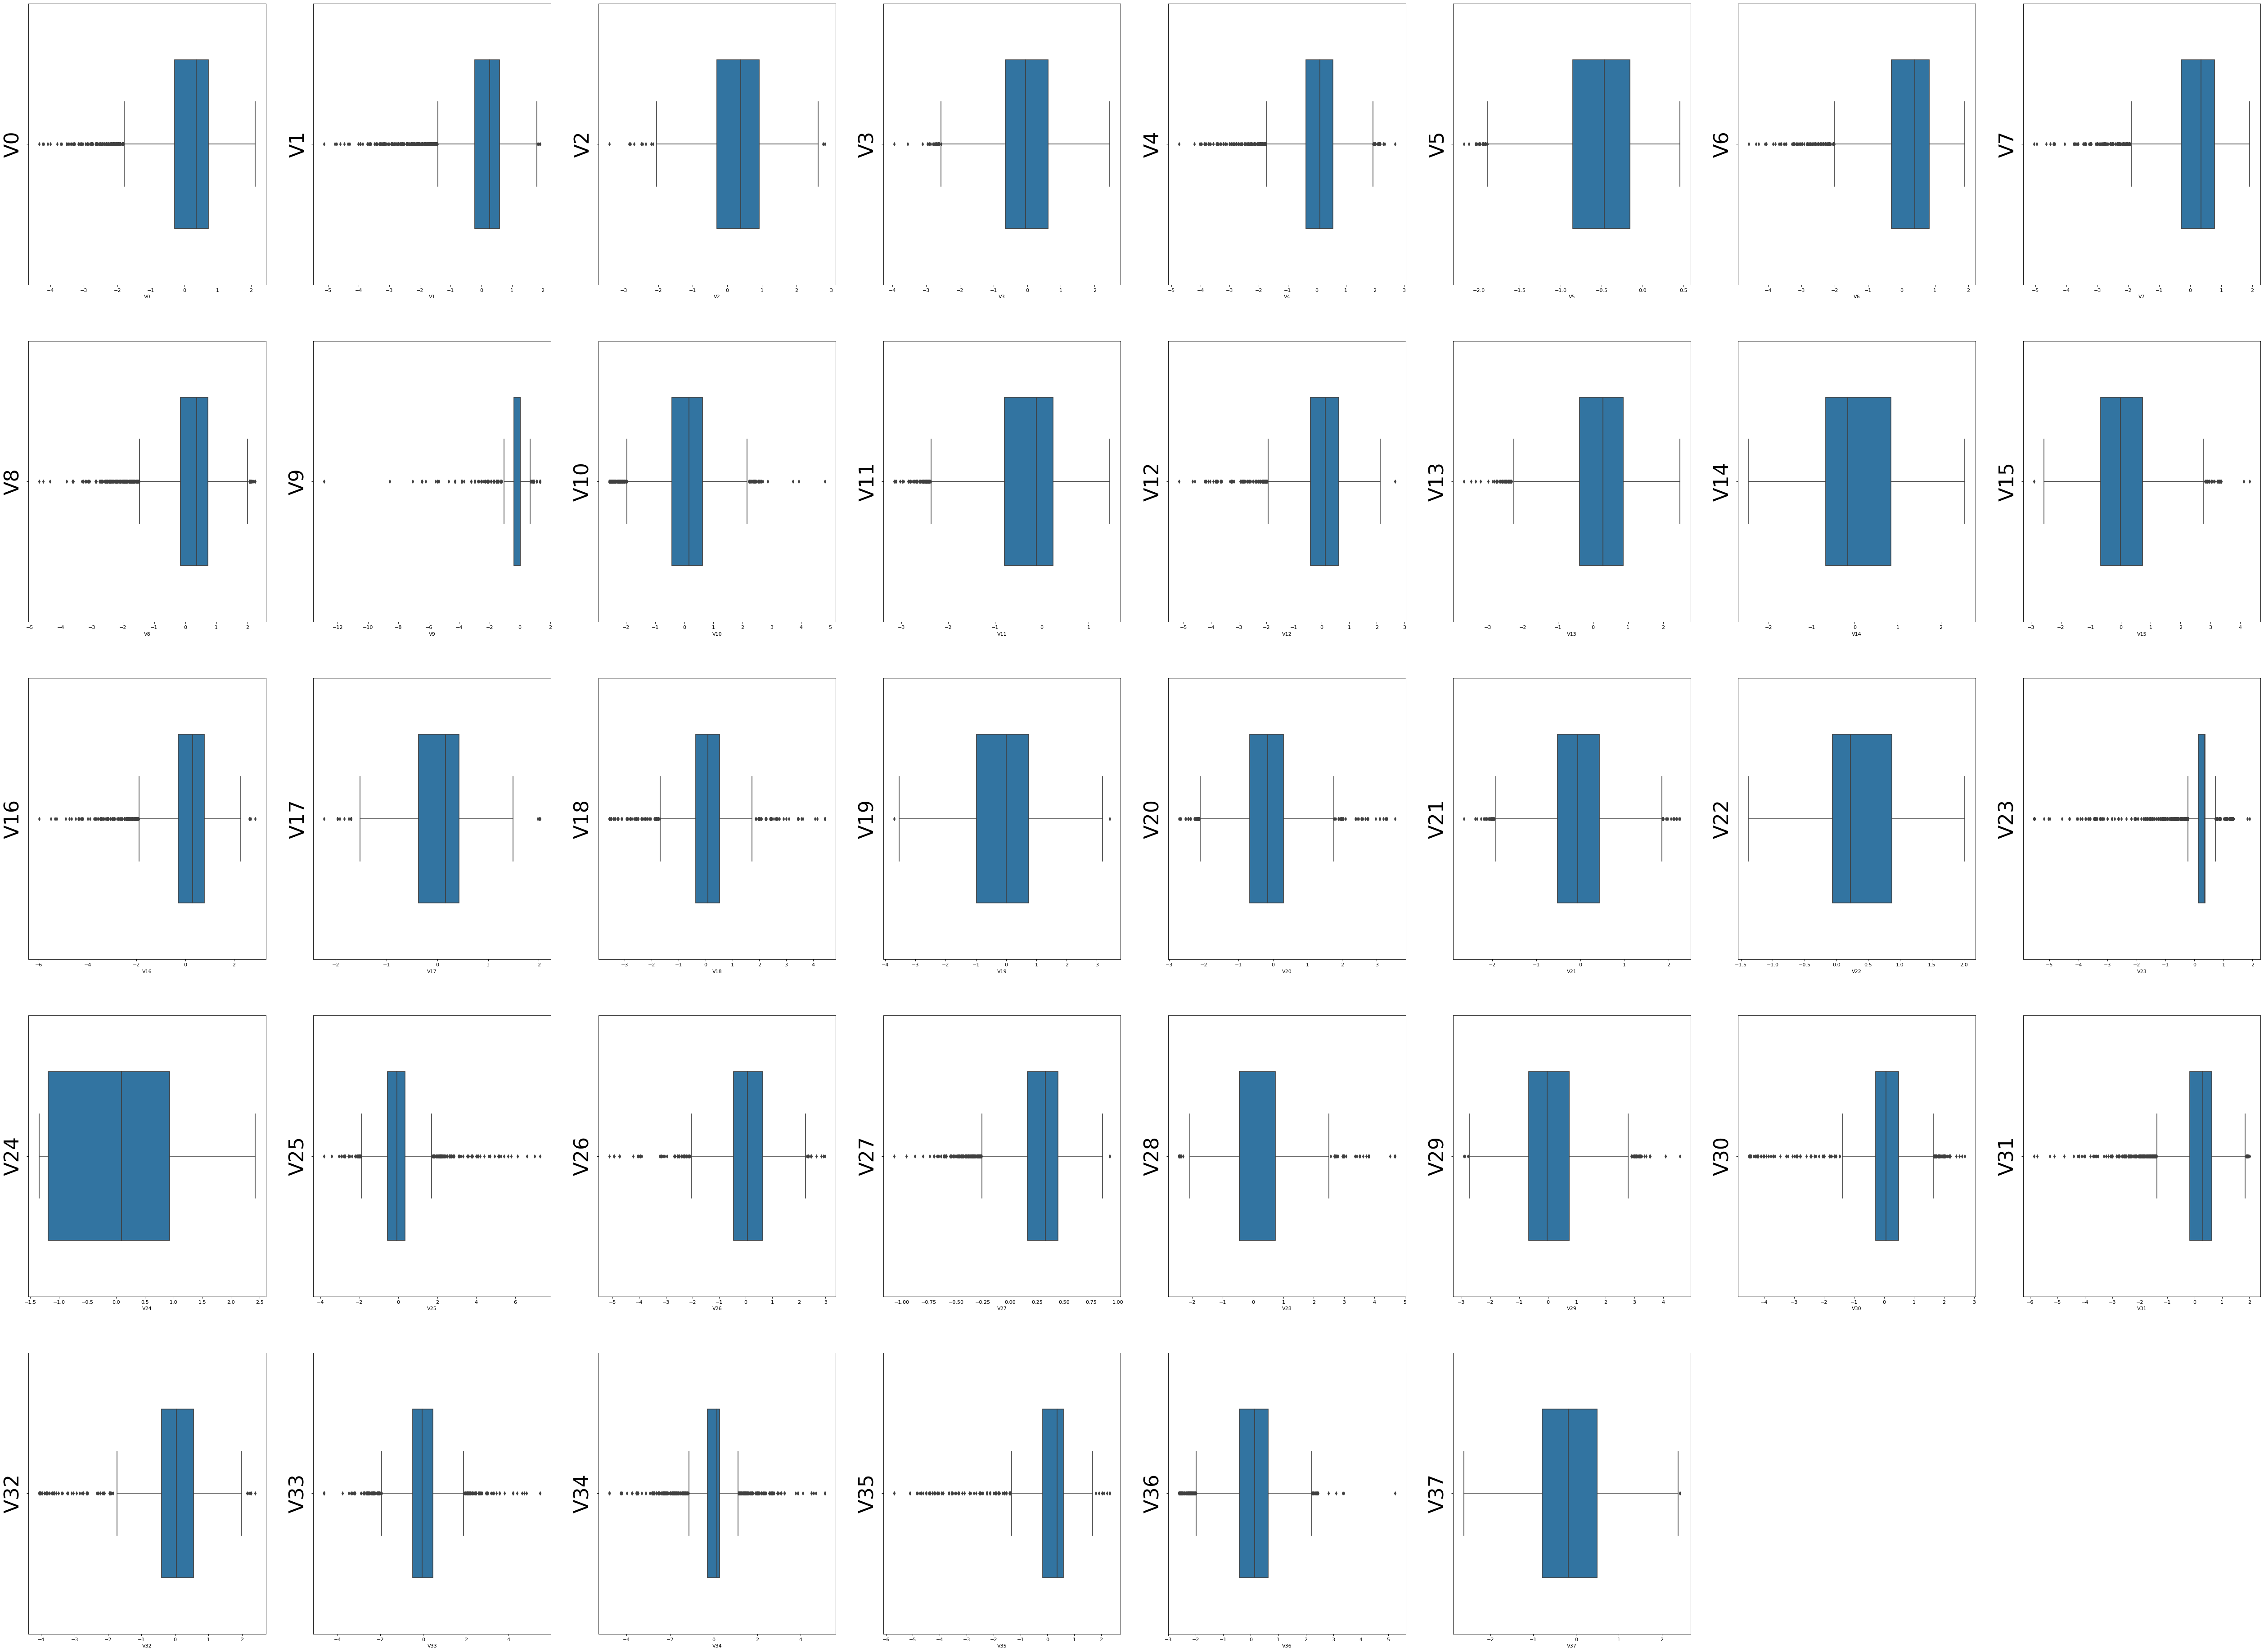

In [11]:
train_column = train_df.columns.tolist()[:38]
fig = plt.figure(figsize=(80, 60), dpi=80)
for i in range(38):
    plt.subplot(5, 8, i+1)
    sns.boxplot(train_df[train_column[i]], orient='h', width=0.6)
    plt.ylabel(train_column[i], fontsize=40)

plt.show()

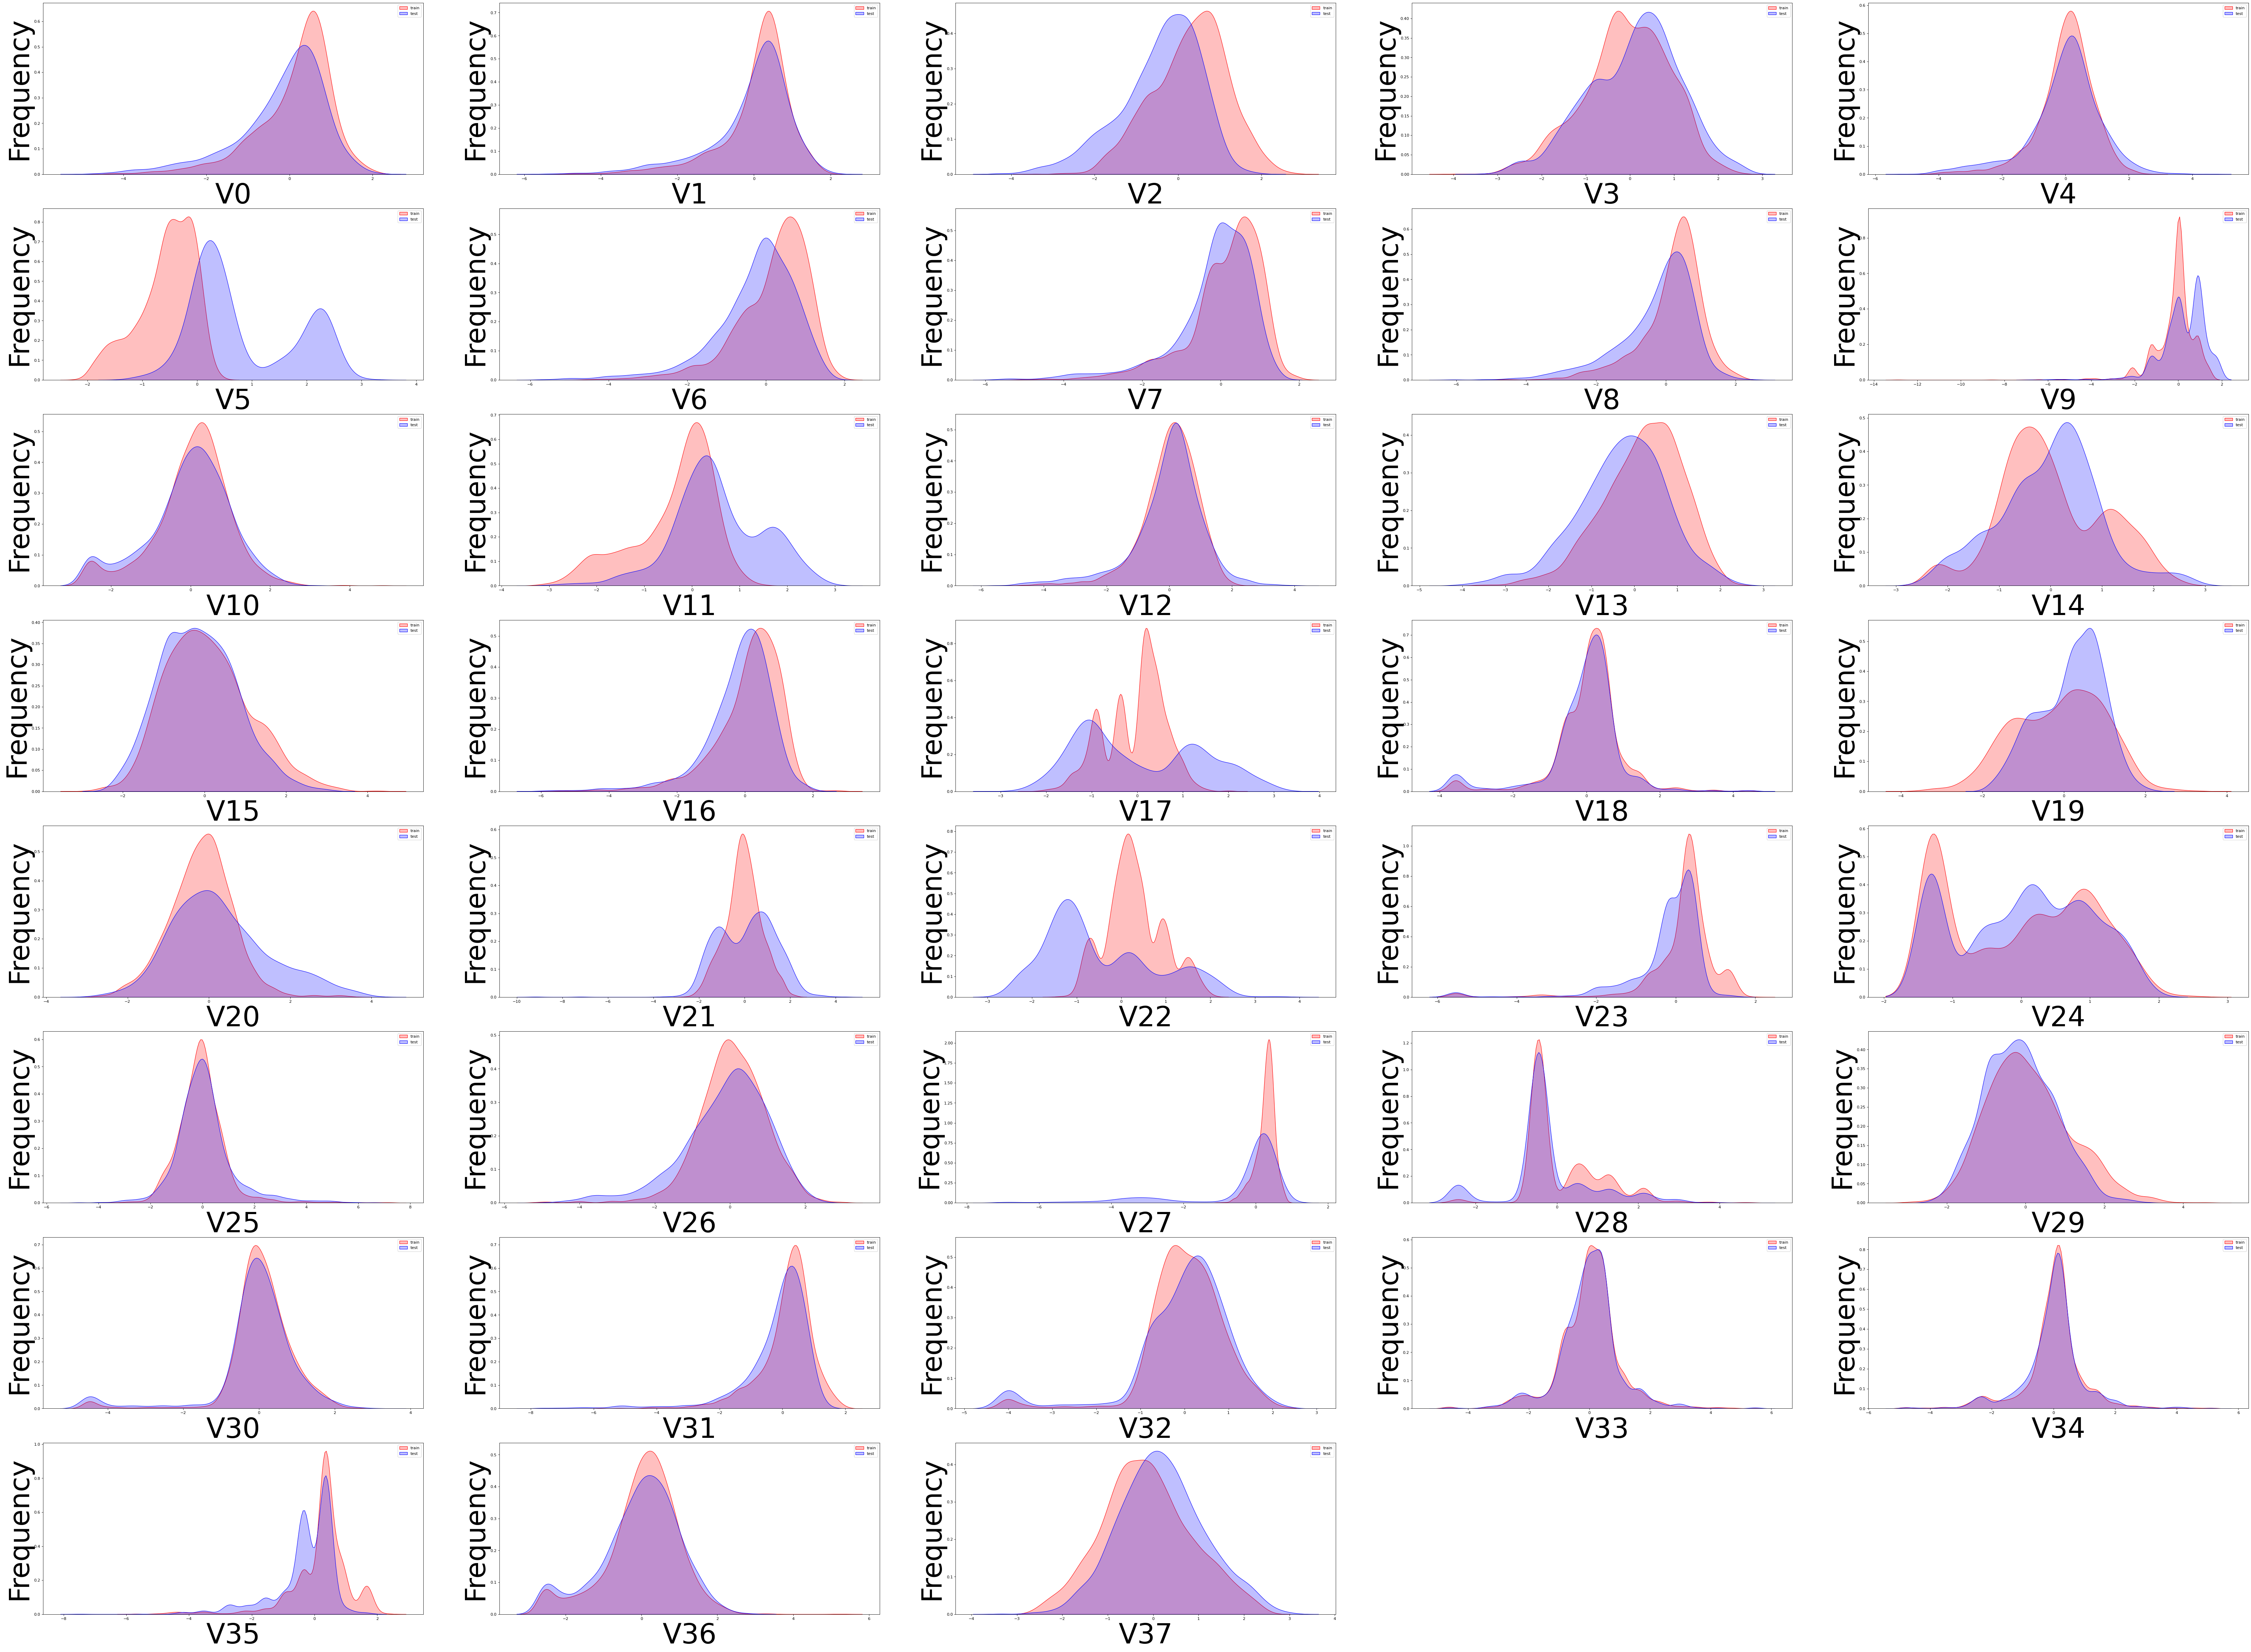

In [12]:
plt.figure(figsize=(100, 75), dpi=80)
for i, col in enumerate(test_df.columns):
    plt.subplot(8, 5, i+1)
    sns.kdeplot(train_df[col], color='Red', shade=True)
    sns.kdeplot(test_df[col], color='Blue', shade=True)
    plt.xlabel(col, fontsize=70)
    plt.ylabel('Frequency', fontsize=70)
    plt.legend(["train", "test"])

plt.show()

In [13]:
new_train_df = train_df.drop(['V5','V9','V11','V14','V17','V21','V22','V27','V35'], axis=1)
new_test_df = test_df.drop(['V5','V9','V11','V14','V17','V21','V22','V27','V35'], axis=1)

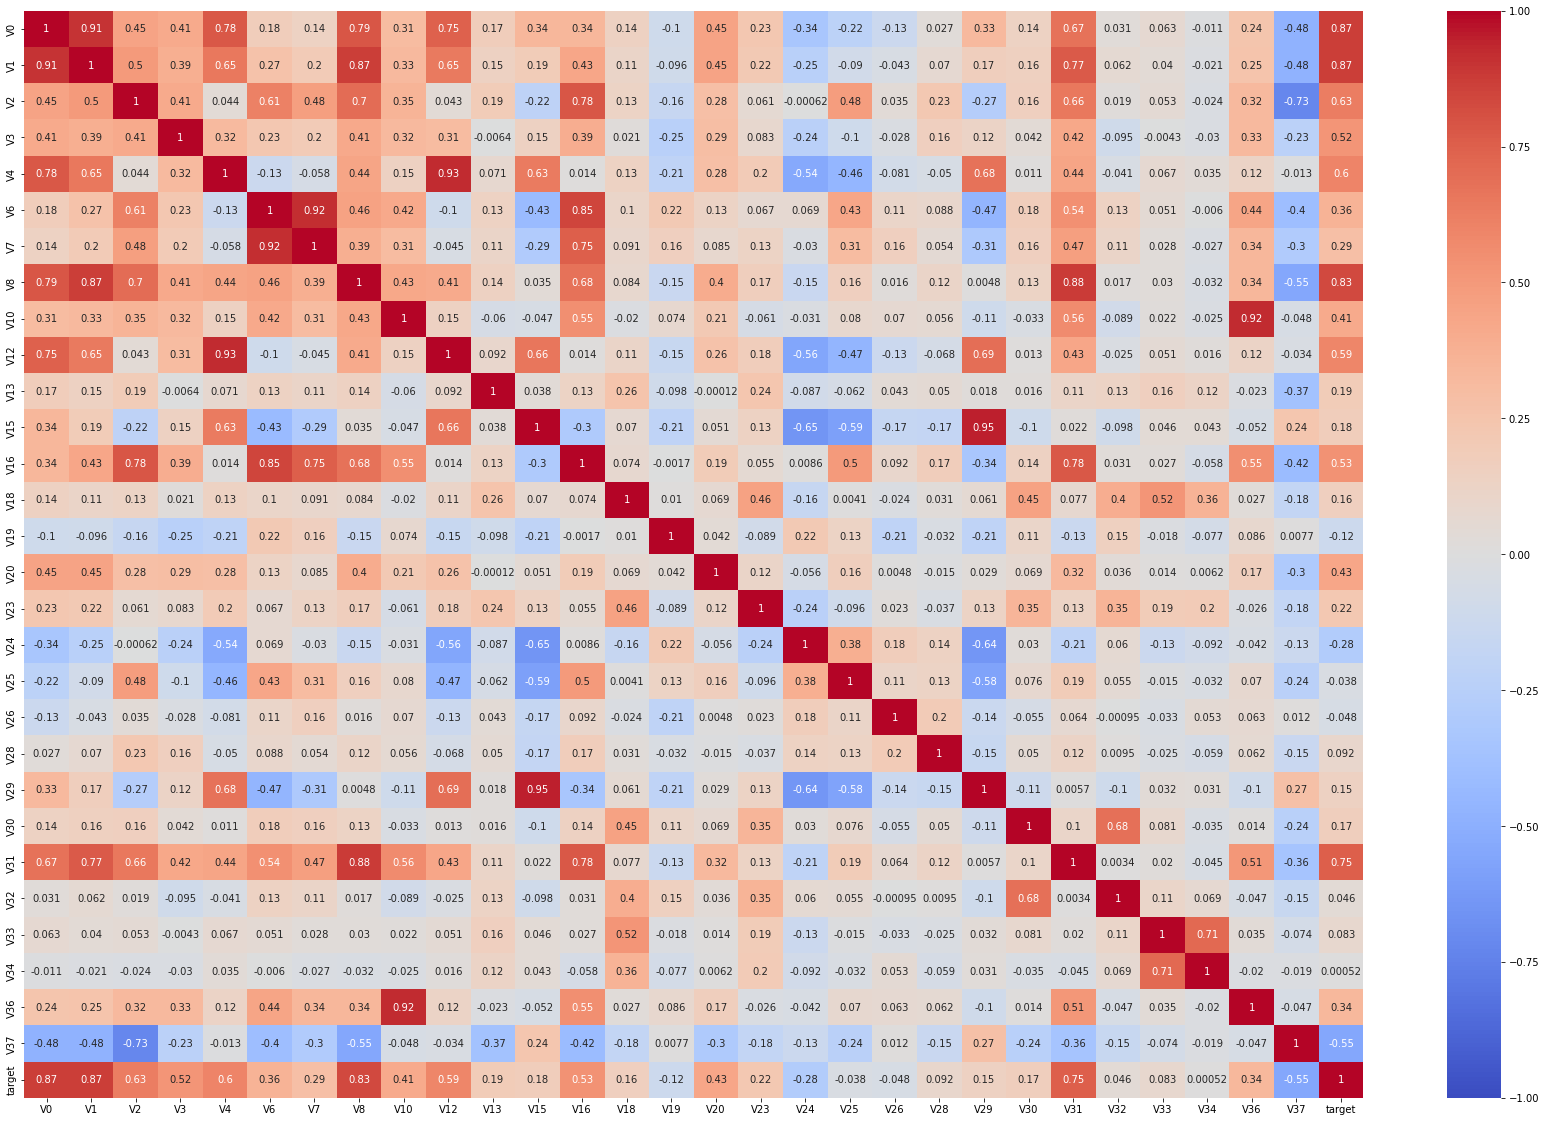

In [14]:
data_corr = new_train_df.corr()
plt.figure(figsize=(30, 20))
sns.heatmap(data_corr, cmap='coolwarm', annot=True, vmin=-1, vmax=1)
plt.show()

In [15]:
threshold = 0.45
corr_matrix = new_train_df.corr().abs()
drop_cols = corr_matrix[corr_matrix['target']<threshold].index
new_train_df.drop(drop_cols, axis=1, inplace=True)
new_test_df.drop(drop_cols, axis=1, inplace=True)

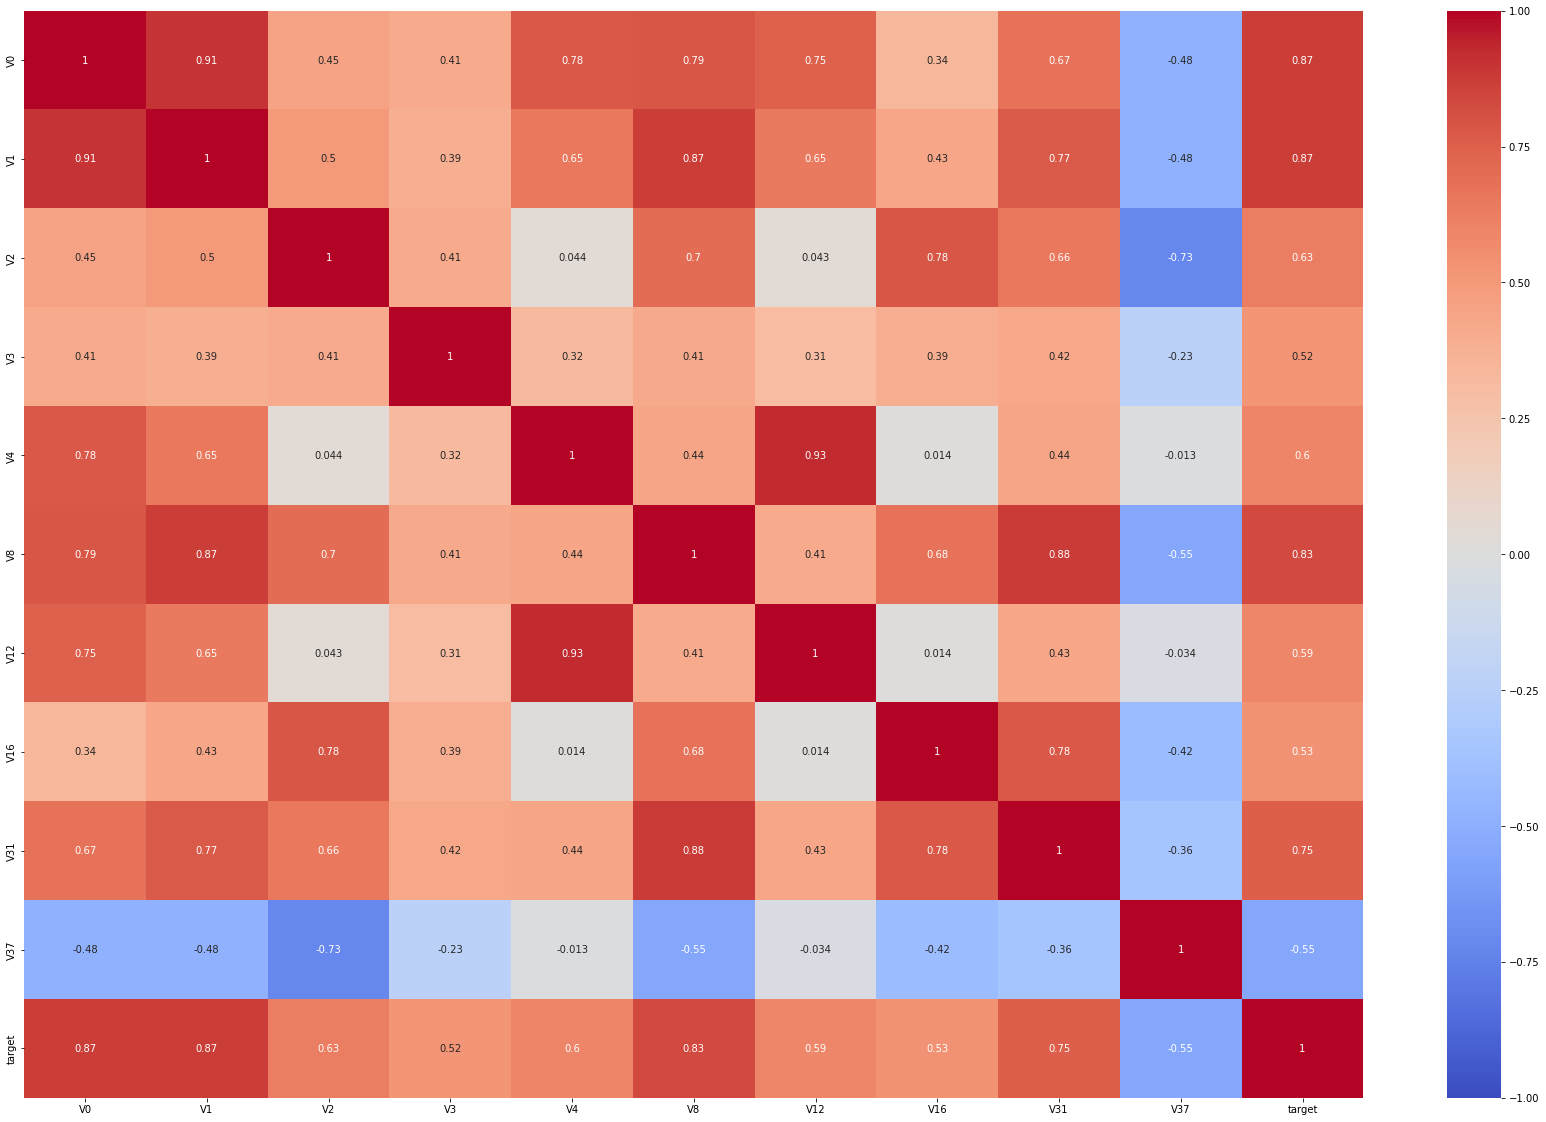

In [16]:
data_corr = new_train_df.corr()
plt.figure(figsize=(30, 20))
sns.heatmap(data_corr, cmap='coolwarm', annot=True, vmin=-1, vmax=1)
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

dt = DecisionTreeRegressor()
svr = SVR()
rf = RandomForestRegressor()
gbdt = GradientBoostingRegressor()

In [18]:
train_label, val_label, train_target, val_target = train_test_split(new_train_df[new_train_df.columns[:-1]], new_train_df['target'], test_size=0.2, shuffle=True, random_state=2023)

In [19]:
param_grid_rf = {
    'n_estimators': [80, 100, 160, 240, 300],
    'max_depth': [3, 5, 8, 10],
    'max_features':[2, 3, 4, 5]
}
param_grid_gb = {
    'n_estimators': [80, 100, 160, 240, 300],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'max_depth': [3, 5, 8, 10],
    'max_features':[2, 3, 4, 5]
}
param_grid_ab = {
    'n_estimators': [80, 100, 160, 240, 300],
    'learning_rate': [0.005, 0.01, 0.05, 0.1]
}
param_grid_bag = {
    "base_estimator":[dt, svr, rf, gbdt],
    'n_estimators': [80, 100, 160, 240, 300],
    'max_features':[2, 3, 4, 5]
}
param_grid_lgb = {
    'n_estimators': [80, 100, 160, 240, 300],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'reg_lambda':[0.8, 1, 1.5, 2]
}
param_grid_xgb = {
    'n_estimators': [80, 100, 160, 240, 300],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'reg_lambda':[0.8, 1, 1.5, 2]
}
# 定义模型列表
models = [
    ('RandomForestRegressor', RandomForestRegressor(), param_grid_rf),
    ('GradientBoostingRegressor', GradientBoostingRegressor(), param_grid_gb),
    ('AdaBoostRegressor', AdaBoostRegressor(), param_grid_ab),
    ('LGBMRegressor', lgb.LGBMRegressor(), param_grid_lgb),
    ('BaggingRegressor', BaggingRegressor(), param_grid_bag),
    ('XGBRegressor', xgb.XGBRegressor(), param_grid_xgb)
]

y_preds = []
# 迭代训练并预测每个模型
for model_name, model, param_grid in tqdm(models):
    print(f"Training and predicting with {model_name}...")

    # 网格搜索参数
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(train_label, train_target)

    # 打印最佳参数和最佳评估指标
    best_params = grid_search.best_params_
    best_score = -grid_search.best_score_
    print(f"Best parameters: {best_params}")
    print(f"Best score: {best_score}")

     # 使用最佳参数进行拟合
    best_model = model.set_params(**best_params)
    best_model.fit(train_label, train_target)

    # 在训练集上计算评估指标
    y_train_pred = best_model.predict(train_label)
    train_mse = mean_squared_error(train_target, y_train_pred)
    print(f"train loss: {train_mse}")

    # 使用最佳参数进行验证
    y_val = best_model.predict(val_label)

    val_mse = mean_squared_error(val_target, y_val)
    print(f"val loss: {val_mse}")
    
    # 使用最佳参数进行验证
    y_pred = best_model.predict(new_test_df)
    y_preds.append(y_pred)
    
    print("-------------------------------------")

  0%|          | 0/6 [00:00<?, ?it/s]

Training and predicting with RandomForestRegressor...
Best parameters: {'max_depth': 10, 'max_features': 3, 'n_estimators': 300}
Best score: 0.13220200732037496


 17%|█▋        | 1/6 [04:03<20:16, 243.39s/it]

train loss: 0.04276225637603493
val loss: 0.12906438019006292
-------------------------------------
Training and predicting with GradientBoostingRegressor...
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 3, 'n_estimators': 300}
Best score: 0.1298115088524689


 33%|███▎      | 2/6 [19:54<43:57, 659.49s/it]

train loss: 0.07780866948117458
val loss: 0.13057547021554833
-------------------------------------
Training and predicting with AdaBoostRegressor...
Best parameters: {'learning_rate': 0.1, 'n_estimators': 300}
Best score: 0.16155188399113918


 50%|█████     | 3/6 [21:28<20:04, 401.52s/it]

train loss: 0.13902511878046586
val loss: 0.16511702421092797
-------------------------------------
Training and predicting with LGBMRegressor...


 67%|██████▋   | 4/6 [24:42<10:39, 319.52s/it]

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 240, 'reg_lambda': 1.5}
Best score: 0.1314491255417924
train loss: 0.09191891530412724
val loss: 0.12894564805888448
-------------------------------------
Training and predicting with BaggingRegressor...
Best parameters: {'base_estimator': SVR(), 'max_features': 5, 'n_estimators': 300}
Best score: 0.13083347992806435
train loss: 0.11421056770299522
val loss: 0.12729036023438176


 83%|████████▎ | 5/6 [3:19:55<1:06:35, 3995.23s/it]

-------------------------------------
Training and predicting with XGBRegressor...


100%|██████████| 6/6 [3:27:02<00:00, 2070.47s/it]  

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 160, 'reg_lambda': 1.5}
Best score: 0.13128717723372382
train loss: 0.07641368004144555
val loss: 0.1340571810579256
-------------------------------------


In [20]:
y_preds

[array([ 0.31592153,  0.20969298, -0.03864225, ..., -2.63547883,
        -2.68139932, -2.51762372]),
 array([ 0.27781369,  0.16139644,  0.01424364, ..., -2.51566058,
        -2.68397033, -2.61578712]),
 array([ 0.27864388,  0.18908926, -0.00563192, ..., -2.2933908 ,
        -2.25137234, -2.31001558]),
 array([ 0.2295859 ,  0.18033196, -0.07894468, ..., -2.5475677 ,
        -2.54598056, -2.44153576]),
 array([ 0.25878762,  0.21253799, -0.08959757, ..., -2.1666706 ,
        -2.40905754, -2.2510057 ]),
 array([ 0.23463458,  0.15755156, -0.04222717, ..., -2.5849059 ,
        -2.636795  , -2.4233994 ], dtype=float32)]

In [28]:
df_result = pd.DataFrame(y_preds[0])

# 将DataFrame写入txt文件
df_result.to_csv("predictions.txt", header=None, index=False, sep="\t")